# Veeam API and Python Part 7 - Veeam API and visualization
In this notebook we will go over how you can visualize  your data with Python.

You will need to install the following:

    pip install pandas bokeh matplotlib

First the imports:

In [59]:
from veeam_easy_connect import VeeamEasyConnect
import requests
import urllib3
urllib3.disable_warnings()
# new
import pandas as pd

## Connect to the APIs

For this we are going to connect to the Enterprise Manager API again

In [60]:
veeam_ec = VeeamEasyConnect()
header = veeam_ec.em_login()

Create the get function

In [61]:
def get_data(url: str, headers: dict) -> dict:
    res = requests.get(url, headers=headers, verify=False)
    res.raise_for_status() # will raise an error if we don't get a 2** status code
    res_data = res.json()
    return res_data

Grab an endpoint from the Veeam Documentation, in this case we will use the **/query?type=BackupFile** endpoint.

[/querySvc backupFile - Help Guide](https://helpcenter.veeam.com/docs/backup/em_rest/get_query_backupfile.html?ver=110)

Note that the &format=Entities means we will get back all the backup file information in a single call.

In [62]:
address = input("Enter Server Address: ")
url = f"https://{address}:9398/api/query?type=BackupFile&format=Entities"

Then make a request to get the data

In [63]:
bu_data = get_data(url, header)

We are going to pull out just the Compression Ratio in this example

In [64]:
filter_bu = []
# creating a new variable for just the backup files
bu_data2 = bu_data['Entities']['BackupFiles']['BackupFiles']

for i in bu_data2:
    data = {
        "CompressRatio": i["CompressRatio"],
        "CreationTimeUtc": i["CreationTimeUtc"],
        "FileType": i["FileType"],
        "jobName": i["Links"][0]["Name"]
    }
    filter_bu.append(data)

Next create the Dataframe 

In [65]:
bu_df = pd.DataFrame.from_dict(filter_bu)

In [66]:
bu_vib = bu_df[bu_df['FileType'] == 'vib'].copy()

In [67]:
bu_vib.sort_values("CompressRatio", ascending=False, inplace=True)

In [68]:
bu_vib.head()

,CompressRatio,CreationTimeUtc,FileType,jobName
20,7.14,2021-08-08T23:06:43.703Z,vib,Mixed SOBR
80,6.67,2021-09-04T19:00:39.033Z,vib,k8s
40,6.67,2021-09-04T19:00:39.033Z,vib,k8s
91,6.67,2021-09-02T19:00:28.98Z,vib,k8s
8,6.67,2021-09-02T19:00:28.98Z,vib,k8s


<AxesSubplot:xlabel='jobName'>

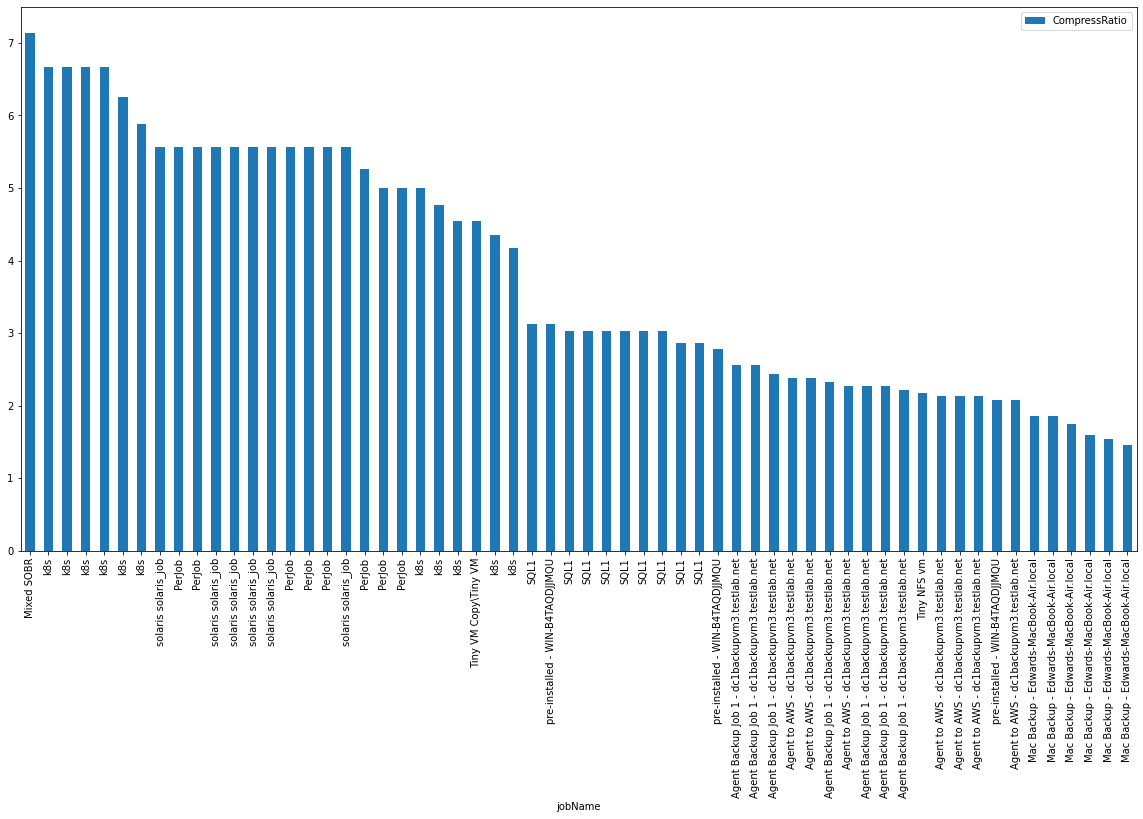

In [69]:
bu_vib.plot.bar(x='jobName', y='CompressRatio', figsize=(20, 10))

In [70]:
bu_grouped = bu_vib.groupby("jobName", as_index=False).mean()

<AxesSubplot:xlabel='jobName'>

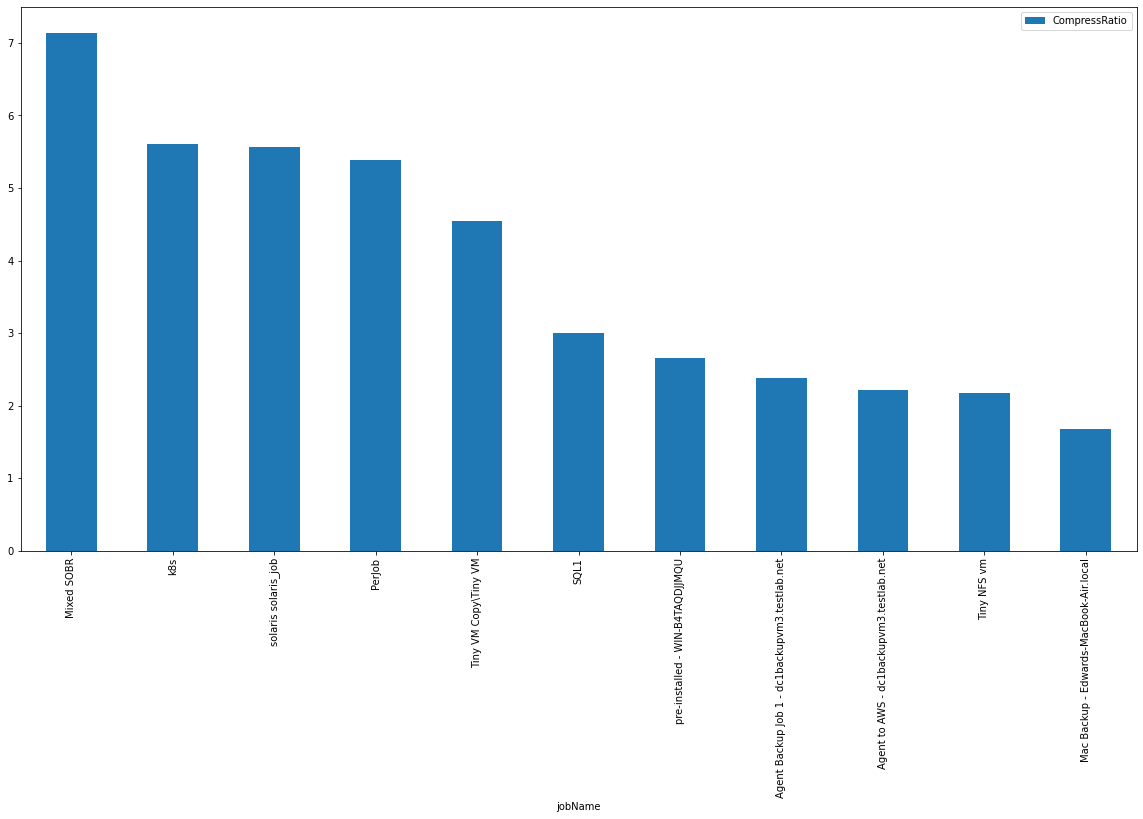

In [71]:
bu_grouped.sort_values("CompressRatio", ascending=False, inplace=True)
bu_grouped.plot.bar(x="jobName", y="CompressRatio", figsize=(20, 10))

# Plotting with Bokeh

In this section we will look at a different library called Bokeh which outputs the plots to a HTML file.

In [80]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_file

In [84]:
source = ColumnDataSource(bu_grouped)
output_file("compression_stats.html")

p = figure(title="Compression Stats",
           width=1000,
           height=600,
           x_axis_label="Job Name",
           y_axis_label="Compression Rate",
           x_range=bu_grouped['jobName']
)
p.xaxis.major_label_orientation = 45
p.vbar(x="jobName", top="CompressRatio", source=source, bottom=0, width=0.5)

show(p)